In [ ]:
# STEP 1: Install required packages
!pip install -q kaggle
!pip install -q pandas matplotlib seaborn scikit-learn xgboost

# STEP 2: Upload kaggle.json (Kaggle API Token)
from google.colab import files
files.upload()  # upload kaggle.json here

# STEP 3: Set up Kaggle API and download dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d lakshmi25npathi/online-retail-dataset
!unzip -q online-retail-dataset.zip

# STEP 4: Load the dataset
import pandas as pd
df = pd.read_excel("online_retail_II.xlsx")
df.head()

Saving kaggle.json to kaggle (2).json
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset
License(s): other
online-retail-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace online_retail_II.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['Customer ID'])

# Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# Remove canceled orders
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Convert date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['Price']

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [ ]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

clv_df = df.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),  # Recency
    Frequency=('InvoiceDate', 'nunique'),  # Frequency
    InvoiceCount=('Invoice', 'nunique'),  # InvoiceCount
    Monetary=('TotalPrice', 'sum')  # Monetary
).reset_index()


# Create CLV target variable (Monetary / Frequency)
clv_df['CLV'] = clv_df['Monetary'] / clv_df['Frequency']
clv_df.head()

,Customer ID,Recency,Frequency,InvoiceCount,Monetary,CLV
0,12346.0,165,11,11,372.86,33.896364
1,12347.0,3,2,2,1323.32,661.660000
2,12348.0,74,1,1,222.16,222.160000
3,12349.0,43,3,3,2671.14,890.380000
4,12351.0,11,1,1,300.93,300.930000


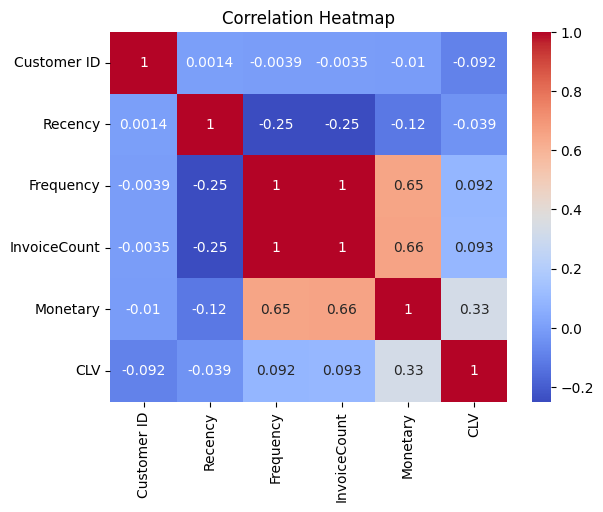

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
sns.heatmap(clv_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

X = clv_df[['Recency', 'Frequency', 'InvoiceCount', 'Monetary']]
y = clv_df['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# Ensemble Prediction
final_pred = (ridge_pred + rf_pred) / 2

# Evaluate
r2 = r2_score(y_test, final_pred)
print("✅ R² Score (Ensemble):", round(r2, 2))


✅ R² Score (Ensemble): 0.67


In [ ]:
# 🧮 Predict CLV for all customers using the trained model
ridge_preds_all = ridge.predict(X)
rf_preds_all = rf.predict(X)

# 🔁 Average the predictions (ensemble output)
clv_df['Predicted_CLV'] = (ridge_preds_all + rf_preds_all) / 2

# 🧾 Export to CSV
clv_df.to_csv("predicted_clv.csv", index=False)

# 📁 Download the file in Colab
from google.colab import files
files.download("predicted_clv.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 🔢 Segment Customers Based on Predicted CLV
def segment_customer(clv):
    if clv >= clv_df['Predicted_CLV'].quantile(0.75):
        return 'VIP'
    elif clv >= clv_df['Predicted_CLV'].quantile(0.50):
        return 'Loyal'
    elif clv >= clv_df['Predicted_CLV'].quantile(0.25):
        return 'Regular'
    else:
        return 'At Risk'

clv_df['Segment'] = clv_df['Predicted_CLV'].apply(segment_customer)

# ✅ View count of customers in each segment
print(clv_df['Segment'].value_counts())


Segment
At Risk    1079
VIP        1079
Regular    1078
Loyal      1078
Name: count, dtype: int64


/tmp/ipython-input-18-2402902658.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=clv_df, x='Segment', order=['VIP', 'Loyal', 'Regular', 'At Risk'], palette='Set2')


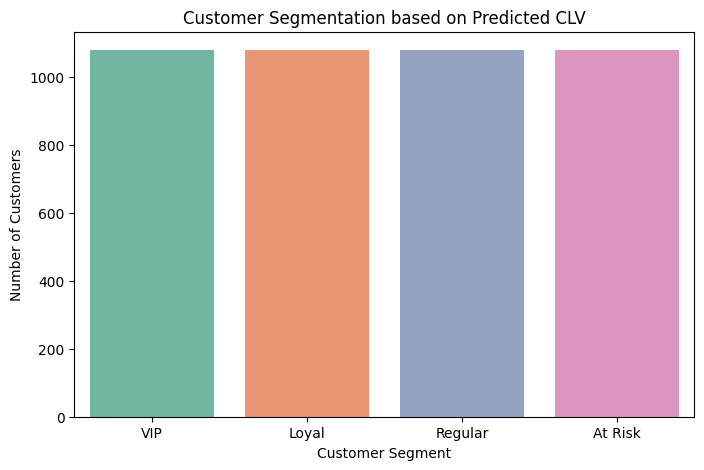

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=clv_df, x='Segment', order=['VIP', 'Loyal', 'Regular', 'At Risk'], palette='Set2')
plt.title("Customer Segmentation based on Predicted CLV")
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.show()


In [ ]:
clv_df.to_csv("predicted_clv_segmented.csv", index=False)

from google.colab import files
files.download("predicted_clv_segmented.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>